# Goal
This post aims to break down the module [`dtreeviz`](https://github.com/parrt/dtreeviz) module step by step to fully understand what is implemented. After fully understanding this, I would like to contribute to this module and submit a pull request. 

I really like this module and would like to see this works for other tree-based modules like XGBoost or Lightgbm. I found [the exact same issue (issues 15)](https://github.com/parrt/dtreeviz/issues/15) in github so I hope I could contribute to this issue.

This post is the 2nd part of the process of breaking down `ShadowDecTree`. 

**Reference**
* [Github dtreeviz](https://github.com/parrt/dtreeviz)
* [Step by Step Data Science - Split-Up: dtreeviz (Part 1)](https://h1ros.github.io/posts/split-up-dtreeviz-part-1/)
* [Scikit-Learn - Tree](https://scikit-learn.org/stable/modules/tree.html)
 

# `ShadowDecTree` class

## Source [github](https://github.com/parrt/dtreeviz/blob/master/dtreeviz/shadow.py)



In [109]:
import numpy as np
import pandas as pd
from collections import defaultdict, Sequence
from typing import Mapping, List, Tuple
from numbers import Number
from sklearn.utils import compute_class_weight
from dtreeviz.shadow import ShadowDecTreeNode 


class ShadowDecTree:
    """
    The decision trees for classifiers and regressors from scikit-learn
    are built for efficiency, not ease of tree walking. This class
    is intended as a way to wrap all of that information in an easy to use
    package.
    This tree shadows a decision tree as constructed by scikit-learn's
    DecisionTree(Regressor|Classifier).  As part of build process, the
    samples considered at each decision node or at each leaf node are
    saved as a big dictionary for use by the nodes.
    Field leaves is list of shadow leaf nodes. Field internal is list of
    shadow non-leaf nodes.
    Field root is the shadow tree root.
    Parameters
    ----------
    class_names : (List[str],Mapping[int,str]). A mapping from target value
                  to target class name. If you pass in a list of strings,
                  target value i must be associated with class name[i]. You
                  can also pass in a dict that maps value to name.
    """
    def __init__(self, tree_model,
                 X_train,
                 y_train,
                 feature_names : List[str],
                 class_names : (List[str],Mapping[int,str])=None):
        self.tree_model = tree_model
        self.feature_names = feature_names
        self.class_names = class_names
        self.class_weight = tree_model.class_weight

        if getattr(tree_model, 'tree_') is None: # make sure model is fit
            tree_model.fit(X_train, y_train)

        if tree_model.tree_.n_classes > 1:
            if isinstance(self.class_names, dict):
                self.class_names = self.class_names
            elif isinstance(self.class_names, Sequence):
                self.class_names = {i:n for i, n in enumerate(self.class_names)}
            else:
                raise Exception(f"class_names must be dict or sequence, not {self.class_names.__class__.__name__}")

        if isinstance(X_train, pd.DataFrame):
            X_train = X_train.values
        self.X_train = X_train
        if isinstance(y_train, pd.Series):
            y_train = y_train.values
        self.y_train = y_train
        self.node_to_samples = ShadowDecTree.node_samples(tree_model, X_train)
        if self.isclassifier():
            self.unique_target_values = np.unique(y_train)
            self.class_weights = compute_class_weight(tree_model.class_weight, self.unique_target_values, self.y_train)

        tree = tree_model.tree_
        children_left = tree.children_left
        children_right = tree.children_right

        # use locals not args to walk() for recursion speed in python
        leaves = []
        internal = [] # non-leaf nodes

        def walk(node_id):
            if (children_left[node_id] == -1 and children_right[node_id] == -1):  # leaf
                t = ShadowDecTreeNode(self, node_id)
                leaves.append(t)
                return t
            else:  # decision node
                left = walk(children_left[node_id])
                right = walk(children_right[node_id])
                t = ShadowDecTreeNode(self, node_id, left, right)
                internal.append(t)
                return t

        root_node_id = 0
        # record root to actual shadow nodes
        self.root = walk(root_node_id)
        self.leaves = leaves
        self.internal = internal

    def nclasses(self):
        return self.tree_model.tree_.n_classes[0]

    def nnodes(self) -> int:
        "Return total nodes in the tree"
        return self.tree_model.tree_.node_count

    def leaf_sample_counts(self) -> List[int]:
        return [self.tree_model.tree_.n_node_samples[leaf.id] for leaf in self.leaves]

    def isclassifier(self):
        return self.tree_model.tree_.n_classes > 1

    def get_split_node_heights(self, X_train, y_train, nbins) -> Mapping[int,int]:
        class_values = self.unique_target_values
        node_heights = {}
        # print(f"Goal {nbins} bins")
        for node in self.internal:
            # print(node.feature_name(), node.id)
            X_feature = X_train[:, node.feature()]
            overall_feature_range = (np.min(X_feature), np.max(X_feature))
            # print(f"range {overall_feature_range}")
            r = overall_feature_range[1] - overall_feature_range[0]

            bins = np.linspace(overall_feature_range[0],
                               overall_feature_range[1], nbins+1)
            # bins = np.arange(overall_feature_range[0],
            #                  overall_feature_range[1] + binwidth, binwidth)
            # print(f"\tlen(bins)={len(bins):2d} bins={bins}")
            X, y = X_feature[node.samples()], y_train[node.samples()]
            X_hist = [X[y == cl] for cl in class_values]
            height_of_bins = np.zeros(nbins)
            for cl in class_values:
                hist, foo = np.histogram(X_hist[cl], bins=bins, range=overall_feature_range)
                # print(f"class {cl}: goal_n={len(bins):2d} n={len(hist):2d} {hist}")
                height_of_bins += hist
            node_heights[node.id] = np.max(height_of_bins)

            # print(f"\tmax={np.max(height_of_bins):2.0f}, heights={list(height_of_bins)}, {len(height_of_bins)} bins")
        return node_heights

    def predict(self, x : np.ndarray) -> Tuple[Number,List]:
        """
        Given an x-vector of features, return predicted class or value based upon
        this tree. Also return path from root to leaf as 2nd value in return tuple.
        Recursively walk down tree from root to appropriate leaf by
        comparing feature in x to node's split value. Also return
        :param x: Feature vector to run down the tree to a leaf.
        :type x: np.ndarray
        :return: Predicted class or value based
        :rtype: Number
        """
        def walk(t, x, path):
            if t is None:
                return None
            path.append(t)
            if t.isleaf():
                return t
            if x[t.feature()] < t.split():
                return walk(t.left, x, path)
            return walk(t.right, x, path)

        path = []
        leaf = walk(self.root, x, path)
        return leaf.prediction(), path

    def tesselation(self):
        """
        Walk tree and return list of tuples containing a leaf node and bounding box
        list of (x1,y1,x2,y2) coordinates
        :return:
        :rtype:
        """
        bboxes = []

        def walk(t, bbox):
            if t is None:
                return None
            # print(f"Node {t.id} bbox {bbox} {'   LEAF' if t.isleaf() else ''}")
            if t.isleaf():
                bboxes.append((t, bbox))
                return t
            # shrink bbox for left, right and recurse
            s = t.split()
            if t.feature()==0:
                walk(t.left,  (bbox[0],bbox[1],s,bbox[3]))
                walk(t.right, (s,bbox[1],bbox[2],bbox[3]))
            else:
                walk(t.left,  (bbox[0],bbox[1],bbox[2],s))
                walk(t.right, (bbox[0],s,bbox[2],bbox[3]))

        # create bounding box in feature space (not zeroed)
        f1_values = self.X_train[:, 0]
        f2_values = self.X_train[:, 1]
        overall_bbox = (np.min(f1_values), np.min(f2_values), # x,y of lower left edge
                        np.max(f1_values), np.max(f2_values)) # x,y of upper right edge
        walk(self.root, overall_bbox)

        return bboxes

    @staticmethod
    def node_samples(tree_model, data) -> Mapping[int, list]:
        """
        Return dictionary mapping node id to list of sample indexes considered by
        the feature/split decision.
        """
        # Doc say: "Return a node indicator matrix where non zero elements
        #           indicates that the samples goes through the nodes."
        dec_paths = tree_model.decision_path(data)

        # each sample has path taken down tree
        node_to_samples = defaultdict(list)
        for sample_i, dec in enumerate(dec_paths):
            _, nz_nodes = dec.nonzero()
            for node_id in nz_nodes:
                node_to_samples[node_id].append(sample_i)

        return node_to_samples

    def __str__(self):
        return str(self.root)


## Instantiate class objects

### Create a tree model by scikit learn

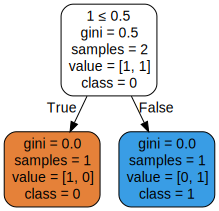

In [93]:
import numpy as np
import graphviz 
from sklearn import tree

X = np.array([[0, 0], [1, 1]])
Y = np.array([0, 1])
# Y = [0, 1]
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)
dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=[0, 1],  
                     class_names=['0', '1'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 


## Create a `ShadowDecTree`

**ShadowDecTree** `__init__`
- L33-41: define `__initi__` with 5 input arguments.
- L38-41: store the input arguments as a class member
- L43-44: check if the trained model exists in `tree_model`, and if not, it enforces to train the tree model.

- L46-52: treatment for multi label classification

- L54-59: treatment for `pandas` if `pandas.DataFrame` is used for `X_train` and `y_train`. Convert them into `np.array`

- L60: a static method `node_samples` in `ShadowDecTree` to create a map from node id in tree_model to list of sample indices. 

- L61-63: treatment for target values and class weights if tree_model is for classification 

- L65-71: preparation for re-organizing tree object into the one for dtreeviz 

- L73-83: define the recursive function to walk through nodes by post order traversal through Depth-First Search (DFS) algorithm. 

- L85-89: execute `walk` method from the root node. Store a list of end nodes as `leaves` and a list of intermediate nodes as `internal`.





In [94]:
# instantiate ShadowDecTree
shadow_tree = ShadowDecTree(tree_model=clf, X_train=X, y_train=Y, feature_names=[0, 1], class_names=[0, 1])

In [95]:
# A root node
shadow_tree.root

In [96]:
# A list of end nodes 
shadow_tree.leaves

In [97]:
# A list of internal nodes
shadow_tree.internal

In [98]:
# A mapping from node id to sample id
shadow_tree.node_to_samples

defaultdict(list, {0: [0, 1], 1: [0], 2: [1]})

## Other methods for `ShadowDecTree`

In [99]:
# L91 nclasses
shadow_tree.nclasses()

2

In [100]:
# L94 nnodes
shadow_tree.nnodes()

3

In [101]:
# L98 leaf_sample_counts
shadow_tree.leaf_sample_counts()

[1, 1]

In [102]:
# L101 isclassifier
shadow_tree.isclassifier()

array([ True])

In [103]:
# L104 get_split_node_heights
nbins = 2
shadow_tree.get_split_node_heights(X_train=X, y_train=Y, nbins=nbins)

{0: 1.0}

In [104]:
print(f"shadow_tree.internal[0].feature(): {shadow_tree.internal[0].feature()}")
X[:, shadow_tree.internal[0].feature()]

shadow_tree.internal[0].feature(): 1


array([0, 1])

In [105]:
# L132 predict
shadow_tree.predict(np.array([0, 0.5]))

(1,
  <__main__.ShadowDecTreeNode at 0x1216dd940>])

In [106]:
# L158 tesselation
shadow_tree.tesselation()

[(<__main__.ShadowDecTreeNode at 0x121696470>, (0, 0, 1, 0.5)),
 (<__main__.ShadowDecTreeNode at 0x1216dd940>, (0, 0.5, 1, 1))]

## Opportunity to contribute
Through line-by-line execution, I found the following opportunities I could potentially contribute to. 
* Add documentation for each methods
* Add validation if it is `np.array` or not for `X_train` and `y_train` since when I pass the list as `X_train` and `y_train`, I got the error for `get_split_node_heights` and `tesselation` like below:
![image](https://user-images.githubusercontent.com/8764683/61387320-e5a62880-a8f0-11e9-874b-7228527abd0a.png)
